## Include related

In [35]:
# !pip install -qU python-gdcm pydicom pylibjpeg
# !pip install -U pylibjpeg-libjpeg -v
# !pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg
# !pip install pydicom

# import include nesscessaryz
import cv2
from PIL import Image, ImageOps
import argparse
import os
import glob
import matplotlib.pyplot as plt
import multiprocessing as mp
from joblib import Parallel, delayed
import pydicom
import time
import numpy as np
import torch
import random
import pandas as pd
from pydicom.pixel_data_handlers import apply_windowing
import imageio
import time
import shutil

In [36]:
dcm = pydicom.dcmread('E:/WORKBASE/Project-rsna-breast-cancer-detection/TheChineseMammographyDatabase/TheChineseMammographyDatabase/CMMD/D1-0038/07-18-2011-NA-NA-73693/1.000000-NA-29651/1-1.dcm')

In [37]:
img = dcm.pixel_array

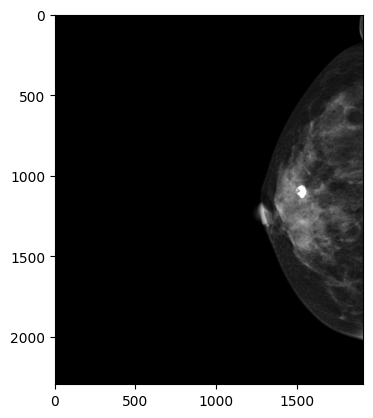

In [38]:
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

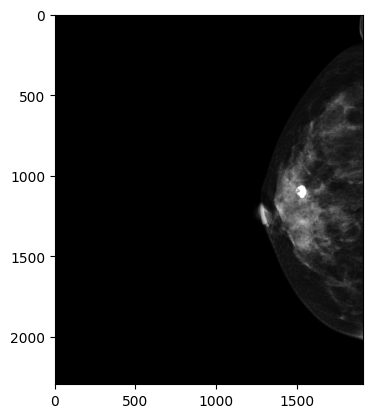

In [39]:
img = apply_windowing(img, dcm)
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

In [40]:
cv2.imwrite('E:/input.png', img)

True

In [41]:
img = (img - img.min()) / (img.max() - img.min())

if dcm.PhotometricInterpretation == "MONOCHROME1":  
    img = 1 - img
image = np.uint8(img * 255)

In [43]:
cv2.imwrite('E:/input.png', image)

True

In [44]:
s = f'python E:/WORKBASE/YOLOXCopy/tools/demo.py image -f E:/WORKBASE/YOLOXCopy/exps/default/yolox_s.py -c E:/WORKBASE/YOLOXCopy/best_ckpt.pth --path E:/WORKBASE/Project-rsna-breast-cancer-detection/DATA_STANDARD/CMMD/MLO_D1-0038-1-1.png --conf 0.8 --nms 0.65 --tsize 416 --save_result --device gpu'
s

'python E:/WORKBASE/YOLOXCopy/tools/demo.py image -f E:/WORKBASE/YOLOXCopy/exps/default/yolox_s.py -c E:/WORKBASE/YOLOXCopy/best_ckpt.pth --path E:/WORKBASE/Project-rsna-breast-cancer-detection/DATA_STANDARD/CMMD/MLO_D1-0038-1-1.png --conf 0.8 --nms 0.65 --tsize 416 --save_result --device gpu'

In [45]:
s

'python E:/WORKBASE/YOLOXCopy/tools/demo.py image -f E:/WORKBASE/YOLOXCopy/exps/default/yolox_s.py -c E:/WORKBASE/YOLOXCopy/best_ckpt.pth --path E:/WORKBASE/Project-rsna-breast-cancer-detection/DATA_STANDARD/CMMD/MLO_D1-0038-1-1.png --conf 0.8 --nms 0.65 --tsize 416 --save_result --device gpu'

In [46]:
!{s}

Total time = 2.5580475330352783


2023-05-12 16:20:07.018 | INFO     | __main__:main:289 - Args: Namespace(demo='image', experiment_name='yolox_s', name=None, path='E:/WORKBASE/Project-rsna-breast-cancer-detection/DATA_STANDARD/CMMD/MLO_D1-0038-1-1.png', camid=0, save_result=True, exp_file='E:/WORKBASE/YOLOXCopy/exps/default/yolox_s.py', ckpt='E:/WORKBASE/YOLOXCopy/best_ckpt.pth', device='gpu', conf=0.8, nms=0.65, tsize=416, fp16=False, legacy=False, fuse=False, trt=False)
2023-05-12 16:20:07.292 | INFO     | __main__:main:299 - Model Summary: Params: 8.95M, Gflops: 11.32
2023-05-12 16:20:07.463 | INFO     | __main__:main:312 - loading checkpoint
2023-05-12 16:20:07.565 | INFO     | __main__:main:316 - loaded checkpoint done.


## Processing Data

In [2]:
from scipy import stats as sst
from crop_image_for_you import *

# META 

In [17]:
meta = pd.read_csv("Data_Main_1024x512/meta_data.csv")

In [18]:
meta = meta[meta.cancer == 1]

In [21]:
meta.head(10)

,Unnamed: 0,image_id,view,age,laterality,cancer
87,87,388811999,MLO,71.0,L,1
88,88,613462606,CC,71.0,L,1
89,89,1360338805,CC,71.0,L,1
90,90,1672636630,MLO,71.0,L,1
190,190,461614796,MLO,71.0,L,1
191,191,530620473,CC,71.0,L,1
215,215,773597682,CC,56.0,L,1
216,216,1803952236,MLO,56.0,L,1
407,407,458553546,CC,65.0,L,1
408,408,1434858530,MLO,65.0,L,1


In [22]:
for i in meta.index:
    path= f'Data_Main_1024x512/Meta_data/{meta.view[i]}_{meta.image_id[i]}.png'
    os.remove(path)

So luong anh no cancer

In [23]:
len(glob.glob('Data_Main_1024x512/Meta_data/*.png'))

53512

In [24]:
len(glob.glob('Data_Main_1024x512/Data_cancer/*.png'))

4015

# RSNA

In [16]:
meta_rsna = pd.read_csv('train.csv/train.csv')
for i in range(len(meta_rsna)):
    if meta_rsna.cancer[i] == 0:
        if meta_rsna.view[i] == 'CC' or meta_rsna.view[i] == 'MLO':
            path1 = f'Image_1024x1024/{meta_rsna.view[i]}_{meta_rsna.image_id[i]}.png'
            path2 = f'RSNA_1024x1024_nocancer/{meta_rsna.view[i]}_{meta_rsna.image_id[i]}.png'
            shutil.move(path1, path2)

In [26]:
from crop_image_for_you import *

# DDSM

In [27]:
ddsm = pd.read_csv(r'D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\DDSM\additional_train.csv')
ddsm['image_id'] = list(range(len(ddsm)))
ddsm.image_id = ddsm.image_id.apply(lambda x: str(x) + "_ddsm")
ddsm.laterality = ddsm.laterality.apply(lambda x: x[0])
# pro1 = Process_Data(ddsm)


In [ ]:
pro1 = Process_Data(ddsm)
ls = list(range(len(ddsm)))
# pro1.my_method(ls)
# Calling the function my_method in the class Process_Data.
pro1.my_method(ls)
# pro1.crop_image_for_you()


In [20]:
new_image = cv2.imread(pro1.path)

In [15]:
os.path.exists(pro1.path)

True

"D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\DDSM\DICOM\P_00001_773\773.dcm"

In [13]:
print(new_image)

None


# Vindr

In [9]:
vindr = 'VinDr-Mammo_Origin_image/metadata.csv'
meta_vin = pd.read_csv(vindr)
meta_vin.head(5)

,SOP Instance UID,Series Instance UID,SOP Instance UID.1,Patient's Age,View Position,Image Laterality,Photometric Interpretation,Rows,Columns,Imager Pixel Spacing,...,Pixel Padding Value,Pixel Padding Range Limit,Window Center,Window Width,Rescale Intercept,Rescale Slope,Rescale Type,Window Center & Width Explanation,Manufacturer,Manufacturer's Model Name
0,d8125545210c08e1b1793a5af6458ee2,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,053Y,CC,L,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1662,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
1,290c658f4e75a3f83ec78a847414297c,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,053Y,MLO,L,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1664,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
2,cd0fc7bc53ac632a11643ac4cc91002a,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,053Y,CC,R,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1600,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
3,71638b1e853799f227492bfb08a01491,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,053Y,MLO,R,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1654,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
4,dd9ce3288c0773e006a294188aadba8e,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,042Y,CC,L,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1580,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration


In [10]:
name_col = meta_vin.columns
rename = {}
for i in name_col:
    rename.update({i:i.replace(' ', '_')})
    # print(i.replace(' ', '_'))
meta_vin =meta_vin.rename(columns=rename)
meta_vin.head(3)

,SOP_Instance_UID,Series_Instance_UID,SOP_Instance_UID.1,Patient's_Age,View_Position,Image_Laterality,Photometric_Interpretation,Rows,Columns,Imager_Pixel_Spacing,...,Pixel_Padding_Value,Pixel_Padding_Range_Limit,Window_Center,Window_Width,Rescale_Intercept,Rescale_Slope,Rescale_Type,Window_Center_&_Width_Explanation,Manufacturer,Manufacturer's_Model_Name
0,d8125545210c08e1b1793a5af6458ee2,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,053Y,CC,L,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1662,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
1,290c658f4e75a3f83ec78a847414297c,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,053Y,MLO,L,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1664,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
2,cd0fc7bc53ac632a11643ac4cc91002a,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,053Y,CC,R,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1600,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration


In [11]:
meta_vin

,SOP_Instance_UID,Series_Instance_UID,SOP_Instance_UID.1,Patient's_Age,View_Position,Image_Laterality,Photometric_Interpretation,Rows,Columns,Imager_Pixel_Spacing,...,Pixel_Padding_Value,Pixel_Padding_Range_Limit,Window_Center,Window_Width,Rescale_Intercept,Rescale_Slope,Rescale_Type,Window_Center_&_Width_Explanation,Manufacturer,Manufacturer's_Model_Name
0,d8125545210c08e1b1793a5af6458ee2,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,053Y,CC,L,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1662,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
1,290c658f4e75a3f83ec78a847414297c,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,053Y,MLO,L,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1664,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
2,cd0fc7bc53ac632a11643ac4cc91002a,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,053Y,CC,R,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1600,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
3,71638b1e853799f227492bfb08a01491,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,053Y,MLO,R,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1654,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
4,dd9ce3288c0773e006a294188aadba8e,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,042Y,CC,L,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,0,NaN,1580,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,ea732154d149f619b20070b78060ae65,2b1b2b8f48abab9819c0b3d091e152ee,ea732154d149f619b20070b78060ae65,038Y,CC,R,MONOCHROME1,2812,2012,"[0.0850, 0.0850]",...,10000,NaN,3574,7148,0,1,US,Default W/L,Planmed,Planmed Nuance
19996,4689616c3d0b46fcba7a771107730791,69d7f07ea04572dad5e5aa62fbcfc4b7,4689616c3d0b46fcba7a771107730791,018Y,CC,R,MONOCHROME2,3580,2702,"[0.0828, 0.0828]",...,0,294.0,"[8338, 8195, 8161, 8283, 8338]","[1828, 1741, 1566, 1915, 1828]",0,1,US,"['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...",IMS s.r.l.,GIOTTO CLASS
19997,3c22491bcf1d0b004715c28d80981cdd,69d7f07ea04572dad5e5aa62fbcfc4b7,3c22491bcf1d0b004715c28d80981cdd,018Y,CC,L,MONOCHROME2,3580,2702,"[0.0828, 0.0828]",...,0,1113.0,"[8457, 8321, 8288, 8404, 8457]","[1735, 1653, 1487, 1818, 1735]",0,1,US,"['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...",IMS s.r.l.,GIOTTO CLASS
19998,d443b9725e331b8b27589aa725597801,69d7f07ea04572dad5e5aa62fbcfc4b7,d443b9725e331b8b27589aa725597801,018Y,MLO,R,MONOCHROME2,3580,2686,"[0.0828, 0.0828]",...,0,294.0,"[8324, 8185, 8152, 8270, 8324]","[1778, 1694, 1524, 1863, 1778]",0,1,US,"['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...",IMS s.r.l.,GIOTTO CLASS


In [35]:
pro1 = Process_Data(meta_vin)
# pro1.set_path(3)
ls = list(range(len(meta_vin)))
pro1.my_method(ls)

AttributeError: 'DataFrame' object has no attribute 'patient_id'

In [17]:
meta_vin[meta_vin['SOP_Instance_UID.1'] == 'a3460d81ca74995b88176f7a76cc2c38']

,SOP_Instance_UID,Series_Instance_UID,SOP_Instance_UID.1,Patient's_Age,View_Position,Image_Laterality,Photometric_Interpretation,Rows,Columns,Imager_Pixel_Spacing,...,Pixel_Padding_Value,Pixel_Padding_Range_Limit,Window_Center,Window_Width,Rescale_Intercept,Rescale_Slope,Rescale_Type,Window_Center_&_Width_Explanation,Manufacturer,Manufacturer's_Model_Name
17833,a3460d81ca74995b88176f7a76cc2c38,82fe4bbc47ed05b374631f0ecd1d7d07,a3460d81ca74995b88176f7a76cc2c38,NaN,CC,R,MONOCHROME1,2812,2012,"[0.0850, 0.0850]",...,10000,NaN,3454,6908,0,1,US,Default W/L,Planmed,Planmed Nuance


In [21]:
len(glob.glob(f'DDSM1024x512forYou/*.png'))

1374

In [ ]:
# import os
# os.chdir(r'/kaggle/working/')
# from IPython.display import FileLink
# !zip -r file.zip '/kaggle/working/'
# FileLink(r'file.zip')

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/MLO_1031443799.png (deflated 0%)
  adding: kaggle/working/MLO_1365269360.png (deflated 0%)
  adding: kaggle/working/MLO_270344397.png (deflated 0%)
  adding: kaggle/working/CC_541722628.png (deflated 0%)
  adding: kaggle/working/MLO_1459541791.png (deflated 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/MLO_1864590858.png (deflated 0%)
  adding: kaggle/working/CC_562340703.png (deflated 0%)
  adding: kaggle/working/CC_1874946579.png (deflated 0%)
  adding: kaggle/working/CC_462822612.png (deflated 0%)
  adding: kaggle/working/CC_220375232.png (deflated 0%)
  adding: kaggle/working/__notebook_source__.ipynb (deflated 44%)


/kaggle/working/file.zip

# Remove Vindr cancer


In [19]:
vincancer = pd.read_csv('VinDr-Mammo_Origin_image/breast-level_annotations.csv')
vincancer = vincancer[vincancer['breast_birads'] == 'BI-RADS 5']
vincancer = vincancer.reset_index()
vincancer.head(10)

,index,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
0,66,10200894bf6f74b2ae92a0cecd37c60c,9c5f1ca701154b6cb7b5481da4def577,581b0e4d471a5c0adc6888cb038fa722,R,CC,3518,2800,BI-RADS 5,DENSITY C,training
1,67,10200894bf6f74b2ae92a0cecd37c60c,9c5f1ca701154b6cb7b5481da4def577,29896919b15b2dd978a36b2f68a5ad93,R,MLO,3518,2800,BI-RADS 5,DENSITY C,training
2,456,450f7f9b2aa32754b076f0f53f0d8efc,eef9cafc933d027583e32c24aca96f78,5d13674e2ed04208bf232e2eeb468f7a,L,CC,3518,2800,BI-RADS 5,DENSITY C,training
3,457,450f7f9b2aa32754b076f0f53f0d8efc,eef9cafc933d027583e32c24aca96f78,d4cae2c614676925578ca87836ab95b6,L,MLO,3518,2800,BI-RADS 5,DENSITY C,training
4,1060,fe23c1647f7617ef219a0a0e07c9eec5,9693e551c7c7d7b5d83d592f93181966,39f3ef0e8046a9b4e6c81262d634053d,L,CC,3518,2800,BI-RADS 5,DENSITY C,training
5,1061,fe23c1647f7617ef219a0a0e07c9eec5,9693e551c7c7d7b5d83d592f93181966,cb02caed6492a9619e93a3bd265a9c7f,L,MLO,3518,2800,BI-RADS 5,DENSITY C,training
6,1316,a0da8d047c71765cdf217a8a52606741,d43fd44f09380e952f8b4cc708613eaa,e61d36901ebb6b37ac41f6ca84e5c81b,L,CC,3518,2800,BI-RADS 5,DENSITY C,training
7,1317,a0da8d047c71765cdf217a8a52606741,d43fd44f09380e952f8b4cc708613eaa,b74f95f32636aff0b94540891c6b1f14,L,MLO,3518,2800,BI-RADS 5,DENSITY C,training
8,1702,a0d75cb5a7be01a0d63f5d9ec553443e,076294a5fb5c7266d8d479cf0358d790,271e8bfd46adee65f8580092753d08e5,R,CC,3518,2800,BI-RADS 5,DENSITY C,training
9,1703,a0d75cb5a7be01a0d63f5d9ec553443e,076294a5fb5c7266d8d479cf0358d790,3c315903764b853c05c059346675e1b7,R,MLO,3518,2800,BI-RADS 5,DENSITY C,training


In [20]:
pro1 = Process_Data(vincancer)
# pro1.set_path(3)
ls = list(range(len(vincancer)))
pro1.my_method(ls)

In [16]:
for i in range(len(vincancer)):
    path1 = f'Vindr1024_512foryou/{vincancer.view_position[i]}_{vincancer.image_id[i]}.png'
    path2 = f'Vindr_cancer_1024x512/{vincancer.view_position[i]}_{vincancer.image_id[i]}.png'
    shutil.move(path1, path2)

In [17]:
len(glob.glob('Vindr_cancer_1024x512/*'))

226

In [18]:
len(glob.glob('Vindr1024_512foryou/*'))

19774

# Data CMMD

In dataset, metadata not clean, we can't specific nocancer img and cancer img
+ I will only get id par have quatity in file clinicaldata == metadata

In [3]:
# os.makedirs('TheChineseMammographyCancer/CMMD/D1-0045/07-18-2010-NA-NA-92358/1.000000-NA-76622/')
os.makedirs('TheChineseMammographyCancer/CMMD/D1-0046/07-18-2010-NA-NA-92358/1.000000-NA-76622/')

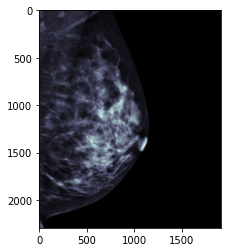

In [4]:
ls = glob.glob('TheChineseMammographyDatabase/CMMD/D1-0045/07-18-2010-NA-NA-92358/1.000000-NA-76622/*.dcm')
img1 = pydicom.dcmread(ls[1])
plt.imshow(img1.pixel_array, cmap=plt.cm.bone)  # set the color map to bone
plt.show()

I think par only views

In [3]:
# Kiem tra nguoi full R
metadata = pd.read_csv("D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\TheChineseMammographyDatabase\TheChineseMammographyDatabase\metadata.csv")
metadata = metadata.loc[:, ['Subject ID', 'File Location']]
clinicaldata = pd.read_excel("D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\TheChineseMammographyDatabase\TheChineseMammographyDatabase\CMMD_clinicaldata_revision.xlsx")
clinicaldata = clinicaldata.loc[:, ['ID1', 'LeftRight', 'classification', 'number' ]]
metadata = metadata.rename(columns={'Subject ID': 'ID1'})
metadata

,ID1,File Location
0,D1-0001,.\CMMD\D1-0001\07-18-2010-NA-NA-79377\1.000000...
1,D1-0002,.\CMMD\D1-0002\07-18-2010-NA-NA-49231\1.000000...
2,D1-0003,.\CMMD\D1-0003\07-18-2011-NA-NA-25491\1.000000...
3,D1-0004,.\CMMD\D1-0004\07-18-2011-NA-NA-14914\1.000000...
4,D1-0007,.\CMMD\D1-0007\07-18-2010-NA-NA-58107\1.000000...
...,...,...
1770,D2-0745,.\CMMD\D2-0745\07-18-2011-NA-NA-87264\1.000000...
1771,D2-0747,.\CMMD\D2-0747\07-18-2011-NA-NA-07955\1.000000...
1772,D2-0746,.\CMMD\D2-0746\07-18-2011-NA-NA-61307\1.000000...
1773,D2-0748,.\CMMD\D2-0748\07-18-2011-NA-NA-50416\1.000000...


In [4]:
meta_china =  pd.merge(clinicaldata, metadata, on=['ID1'])
# meta_china = meta_china[meta_china['classification'] == 'Malignant']
meta_china = meta_china.reset_index()
meta_china[meta_china.ID1 == 'D1-0087']

,index,ID1,LeftRight,classification,number,File Location
68,68,D1-0087,L,Benign,2,.\CMMD\D1-0087\07-18-2010-NA-NA-34194\1.000000...
69,69,D1-0087,R,Malignant,2,.\CMMD\D1-0087\07-18-2010-NA-NA-34194\1.000000...


"D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\DDSM\DICOM\P_00001_773\773.dcm"

In [5]:
meta_china.to_csv('meta_china_cancer.csv')

### Preprocess CMMD

In [6]:
# data_cmmd_cancer = pd.read_csv('Cmmd_external-1.csv')
data_cmmd_all = pd.read_csv("meta_china_all.csv")
# data_cmmd_cancer.head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'meta_china_all.csv'

In [11]:
data_cmmd_all = data_cmmd_all.drop('Unnamed: 0', axis=1)

NameError: name 'data_cmmd_all' is not defined

In [100]:
data_cmmd_all  =  data_cmmd_all[data_cmmd_all['cancer'] == 1]
data_cmmd_cancer = data_cmmd_cancer[data_cmmd_cancer['cancer'] ==  1]

In [29]:
data_cmmd_all.head(10)

,patient_id,image_id,laterality,cancer,path
116,D1-0045,116,L,1,TheChineseMammographyDatabase/CMMD/D1-0045/07-...
117,D1-0045,117,L,1,TheChineseMammographyDatabase/CMMD/D1-0045/07-...
118,D1-0046,118,R,1,TheChineseMammographyDatabase/CMMD/D1-0046/07-...
119,D1-0046,119,R,1,TheChineseMammographyDatabase/CMMD/D1-0046/07-...
120,D1-0047,120,R,1,TheChineseMammographyDatabase/CMMD/D1-0047/07-...
121,D1-0047,121,R,1,TheChineseMammographyDatabase/CMMD/D1-0047/07-...
122,D1-0051,122,R,1,TheChineseMammographyDatabase/CMMD/D1-0051/07-...
123,D1-0051,123,R,1,TheChineseMammographyDatabase/CMMD/D1-0051/07-...
124,D1-0053,124,R,1,TheChineseMammographyDatabase/CMMD/D1-0053/07-...
125,D1-0053,125,R,1,TheChineseMammographyDatabase/CMMD/D1-0053/07-...


In [31]:
os.path.basename(data_cmmd_all.path[116])

'1-1.dcm'

In [53]:
data_cmmd_cancer =data_cmmd_cancer.drop('path_img', axis=1)

In [54]:
data_cmmd_cancer

,patient_id,laterality,age,img_id,view,cancer
116,D1-0045,L,33,D1-0045_1-1,MLO,1
117,D1-0045,L,33,D1-0045_1-2,CC,1
118,D1-0046,R,43,D1-0046_1-1,MLO,1
119,D1-0046,R,43,D1-0046_1-2,CC,1
120,D1-0047,R,43,D1-0047_1-1,MLO,1
...,...,...,...,...,...,...
5580,D2-0747,R,53,D2-0747_1-4,CC,1
5583,D2-0748,R,29,D2-0748_1-3,MLO,1
5584,D2-0748,R,29,D2-0748_1-4,CC,1
5586,D2-0749,L,42,D2-0749_1-2,CC,1


In [ ]:
# Cúng ta cần hợp nhất cột id 

In [48]:
path_cmmd1024 = glob.glob('CMMD_1024x512foryou/*.png')
for path in path_cmmd1024:
    if 'MLO_D1-0045_1-1' in path: continue
    # print(path.split('_')[0])
    
    id = int(os.path.basename(path).split('_')[0])
    id_path = os.path.basename(data_cmmd_all.path[id]).split('.')[0]
    
    id_1 = f'{data_cmmd_all.patient_id[id]}_{id_path}'
    views = data_cmmd_cancer[data_cmmd_cancer['img_id'] == id_1].get('view').values[0]
    # print(data_cmmd_cancer[data_cmmd_cancer['img_id'] == id_1])
    # # print(id_1)
    os.rename(path, f'CMMD_1024x512foryou/{views}_{id_1}.png')

In [46]:
path_cmmd1024

['CMMD_1024x1024foryou\\116_D1-0045_L.png',
 'CMMD_1024x1024foryou\\117_D1-0045_L.png',
 'CMMD_1024x1024foryou\\118_D1-0046_R.png',
 'CMMD_1024x1024foryou\\119_D1-0046_R.png',
 'CMMD_1024x1024foryou\\120_D1-0047_R.png',
 'CMMD_1024x1024foryou\\121_D1-0047_R.png',
 'CMMD_1024x1024foryou\\122_D1-0051_R.png',
 'CMMD_1024x1024foryou\\123_D1-0051_R.png',
 'CMMD_1024x1024foryou\\124_D1-0053_R.png',
 'CMMD_1024x1024foryou\\125_D1-0053_R.png',
 'CMMD_1024x1024foryou\\126_D1-0055_R.png',
 'CMMD_1024x1024foryou\\127_D1-0055_R.png',
 'CMMD_1024x1024foryou\\128_D1-0056_L.png',
 'CMMD_1024x1024foryou\\129_D1-0056_L.png',
 'CMMD_1024x1024foryou\\130_D1-0058_R.png',
 'CMMD_1024x1024foryou\\131_D1-0058_R.png',
 'CMMD_1024x1024foryou\\132_D1-0059_R.png',
 'CMMD_1024x1024foryou\\133_D1-0059_R.png',
 'CMMD_1024x1024foryou\\134_D1-0061_R.png',
 'CMMD_1024x1024foryou\\135_D1-0061_R.png',
 'CMMD_1024x1024foryou\\136_D1-0063_L.png',
 'CMMD_1024x1024foryou\\137_D1-0063_L.png',
 'CMMD_1024x1024foryou\\138_D1-0

In [44]:
data_cmmd_cancer[data_cmmd_cancer['img_id'] == 'D1-0045_1-1'].get('view').values[0]

'MLO'

In [26]:
data_cmmd_all.path[116]

'TheChineseMammographyDatabase/CMMD/D1-0045/07-18-2010-NA-NA-92358/1.000000-NA-76622\\1-1.dcm'

In [27]:
len(glob.glob('CMMD_1024x1024foryou/*.png'))

2633

In [28]:
glob.glob('CMMD_1024x1024foryou/*.png')[1]

'CMMD_1024x1024foryou\\117_D1-0045_L.png'

In [16]:
meta_china

,index,ID1,LeftRight,classification,number,File Location
0,0,D1-0001,R,Benign,2,.\CMMD\D1-0001\07-18-2010-NA-NA-79377\1.000000...
1,1,D1-0002,L,Benign,2,.\CMMD\D1-0002\07-18-2010-NA-NA-49231\1.000000...
2,2,D1-0003,L,Benign,2,.\CMMD\D1-0003\07-18-2011-NA-NA-25491\1.000000...
3,3,D1-0004,L,Benign,2,.\CMMD\D1-0004\07-18-2011-NA-NA-14914\1.000000...
4,4,D1-0005,R,Benign,2,.\CMMD\D1-0005\07-18-2011-NA-NA-52347\1.000000...
...,...,...,...,...,...,...
1867,1867,D2-0745,L,Malignant,2,.\CMMD\D2-0745\07-18-2011-NA-NA-87264\1.000000...
1868,1868,D2-0746,R,Malignant,2,.\CMMD\D2-0746\07-18-2011-NA-NA-61307\1.000000...
1869,1869,D2-0747,R,Malignant,2,.\CMMD\D2-0747\07-18-2011-NA-NA-07955\1.000000...
1870,1870,D2-0748,R,Malignant,2,.\CMMD\D2-0748\07-18-2011-NA-NA-50416\1.000000...


# Create CSV 

In [7]:
meta_china

,index,ID1,LeftRight,classification,number,File Location
0,0,D1-0001,R,Benign,2,.\CMMD\D1-0001\07-18-2010-NA-NA-79377\1.000000...
1,1,D1-0002,L,Benign,2,.\CMMD\D1-0002\07-18-2010-NA-NA-49231\1.000000...
2,2,D1-0003,L,Benign,2,.\CMMD\D1-0003\07-18-2011-NA-NA-25491\1.000000...
3,3,D1-0004,L,Benign,2,.\CMMD\D1-0004\07-18-2011-NA-NA-14914\1.000000...
4,4,D1-0005,R,Benign,2,.\CMMD\D1-0005\07-18-2011-NA-NA-52347\1.000000...
...,...,...,...,...,...,...
1867,1867,D2-0745,L,Malignant,2,.\CMMD\D2-0745\07-18-2011-NA-NA-87264\1.000000...
1868,1868,D2-0746,R,Malignant,2,.\CMMD\D2-0746\07-18-2011-NA-NA-61307\1.000000...
1869,1869,D2-0747,R,Malignant,2,.\CMMD\D2-0747\07-18-2011-NA-NA-07955\1.000000...
1870,1870,D2-0748,R,Malignant,2,.\CMMD\D2-0748\07-18-2011-NA-NA-50416\1.000000...


In [8]:
from tqdm.notebook import tqdm

In [40]:
meta_china[meta_china.ID1 == 'D1-0087']

,index,ID1,LeftRight,classification,number,File Location
68,68,D1-0087,L,Benign,2,.\CMMD\D1-0087\07-18-2010-NA-NA-34194\1.000000...
69,69,D1-0087,R,Malignant,2,.\CMMD\D1-0087\07-18-2010-NA-NA-34194\1.000000...


In [9]:
full_left = []
full_right = []
id = 0
meta_china_cancer = pd.DataFrame(columns=['patient_id', 'image_id', 'laterality', 'cancer', 'path'])  

for i in tqdm(range(len(meta_china)), desc='Calculating'):
    path = meta_china['File Location'][i].replace('\\', '/').replace('.', '', 1)
    # lat_cancer = meta_china.LeftRight[i]
    # print(f'D:/OneDrive - Industrial University of HoChiMinh City/WORKBASE/Project-rsna-breast-cancer-detection/TheChineseMammographyDatabase/TheChineseMammographyDatabase{path}')
    # print(glob.glob(f'D:/OneDrive - Industrial University of HoChiMinh City/WORKBASE/Project-rsna-breast-cancer-detection/TheChineseMammographyDatabase/TheChineseMammographyDatabase{path}/*.dcm'))
    for p in glob.glob(f'D:/OneDrive - Industrial University of HoChiMinh City/WORKBASE/Project-rsna-breast-cancer-detection/TheChineseMammographyDatabase/TheChineseMammographyDatabase{path}/*.dcm'):
        # meta_china_cancer.loc[id]  = [meta_china.ID1[i], id, ]
        # meta_china_cancer['patient_id'][id] = meta_china.ID1[i]
        # meta_china_cancer['image_id'][id] = id
        dicom = pydicom.dcmread(p)
        img = dicom.pixel_array
    
            
        img = apply_windowing(img, dicom)
        img = (img - img.min()) / (img.max() - img.min())

        if dicom.PhotometricInterpretation == "MONOCHROME1":  
            img = 1 - img
        
        h, w = img.shape
        left = np.sum(img[: , : int(w/2)])
        right = np.sum(img[: , int(w/2)+1 : ])
        la = None
        if left > right: la = 'L'
        else:  la = 'R'
        tmp_cancer = ''
        if meta_china.LeftRight[i] != la:
            continue
        if meta_china.LeftRight[i] == la and meta_china.classification[i] == 'Malignant': tmp_cancer = 1
        else: tmp_cancer = 0
        meta_china_cancer.loc[id]  = [meta_china.ID1[i], id, la, tmp_cancer,p]
        # image = np.uint8(img * 255)
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        # la  =meta_china_cancer['laterality'][id]
        # imageio.imwrite(f'TheChineseMammographyCancer/{id}_{meta_china.ID1[i]}_{la}.png', img)
        id+=1

# meta_china_cancer['patient_id'][1] = 1 5202 
# meta_china_cancer.to_csv('TheChineseMammographyCancer/meta_china_all')
# meta_china_cancer.to_csv('CMMD_1024x512foryou/meta_china_cancer')

Calculating:   0%|          | 0/1872 [00:00<?, ?it/s]

In [50]:
os.path.basename(meta_china_cancer.path[0])

'1-1.dcm'

In [10]:
meta_china_cancer.image_id.apply()

,patient_id,image_id,laterality,cancer,path
0,D1-0001,0,R,0,D:/OneDrive - Industrial University of HoChiMi...
1,D1-0001,1,R,0,D:/OneDrive - Industrial University of HoChiMi...
2,D1-0002,2,L,0,D:/OneDrive - Industrial University of HoChiMi...
3,D1-0002,3,L,0,D:/OneDrive - Industrial University of HoChiMi...
4,D1-0003,4,L,0,D:/OneDrive - Industrial University of HoChiMi...
...,...,...,...,...,...
3736,D2-0747,3736,R,1,D:/OneDrive - Industrial University of HoChiMi...
3737,D2-0748,3737,R,1,D:/OneDrive - Industrial University of HoChiMi...
3738,D2-0748,3738,R,1,D:/OneDrive - Industrial University of HoChiMi...
3739,D2-0749,3739,L,1,D:/OneDrive - Industrial University of HoChiMi...


In [14]:
## Get view
views = pd.read_csv("D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\Cmmd_external-1.csv")
views

,Unnamed: 0,path_img,patient_id,laterality,age,img_id,view,cancer
0,0,/kaggle/input/cmmd2022/TheChineseMammographyDa...,D1-0001,R,44,D1-0001_1-1,MLO,0
1,1,/kaggle/input/cmmd2022/TheChineseMammographyDa...,D1-0001,R,44,D1-0001_1-2,CC,0
2,2,/kaggle/input/cmmd2022/TheChineseMammographyDa...,D1-0002,L,40,D1-0002_1-1,MLO,0
3,3,/kaggle/input/cmmd2022/TheChineseMammographyDa...,D1-0002,L,40,D1-0002_1-2,CC,0
4,4,/kaggle/input/cmmd2022/TheChineseMammographyDa...,D1-0003,L,39,D1-0003_1-2,CC,0
...,...,...,...,...,...,...,...,...
5585,5585,/kaggle/input/cmmd2022/TheChineseMammographyDa...,D2-0748,R,29,D2-0748_1-2,CC,0
5586,5586,/kaggle/input/cmmd2022/TheChineseMammographyDa...,D2-0749,L,42,D2-0749_1-2,CC,1
5587,5587,/kaggle/input/cmmd2022/TheChineseMammographyDa...,D2-0749,L,42,D2-0749_1-4,CC,0
5588,5588,/kaggle/input/cmmd2022/TheChineseMammographyDa...,D2-0749,L,42,D2-0749_1-3,MLO,0


In [15]:
meta_china_cancer = meta_china_cancer.reset_index()
meta_china_cancer

,index,patient_id,image_id,laterality,cancer,path
0,0,D1-0001,0,R,0,D:/OneDrive - Industrial University of HoChiMi...
1,1,D1-0001,1,R,0,D:/OneDrive - Industrial University of HoChiMi...
2,2,D1-0002,2,L,0,D:/OneDrive - Industrial University of HoChiMi...
3,3,D1-0002,3,L,0,D:/OneDrive - Industrial University of HoChiMi...
4,4,D1-0003,4,L,0,D:/OneDrive - Industrial University of HoChiMi...
...,...,...,...,...,...,...
3736,3736,D2-0747,3736,R,1,D:/OneDrive - Industrial University of HoChiMi...
3737,3737,D2-0748,3737,R,1,D:/OneDrive - Industrial University of HoChiMi...
3738,3738,D2-0748,3738,R,1,D:/OneDrive - Industrial University of HoChiMi...
3739,3739,D2-0749,3739,L,1,D:/OneDrive - Industrial University of HoChiMi...


In [29]:
list_views = []

In [30]:
for i in range(len(meta_china_cancer)):
    name = os.path.basename(meta_china_cancer.path[i]).split('.')[0]
    meta_china_cancer.image_id[i] = f'{meta_china_cancer.patient_id[i]}_{name}'
    # print(views[views.img_id == meta_china_cancer.image_id[i]].view.values[0])
    list_views.append(views[views.img_id == meta_china_cancer.image_id[i]].view.values[0])
    # print(f'{meta_china_cancer.patient_id[i]}_{name}')

C:\Users\nguye\AppData\Local\Temp\ipykernel_18528\3409367599.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_china_cancer.image_id[i] = f'{meta_china_cancer.patient_id[i]}_{name}'


In [32]:
meta_china_cancer['view']  = list_views

In [33]:
meta_china_cancer

,index,patient_id,image_id,laterality,cancer,path,view
0,0,D1-0001,D1-0001_1-1,R,0,D:/OneDrive - Industrial University of HoChiMi...,MLO
1,1,D1-0001,D1-0001_1-2,R,0,D:/OneDrive - Industrial University of HoChiMi...,CC
2,2,D1-0002,D1-0002_1-1,L,0,D:/OneDrive - Industrial University of HoChiMi...,MLO
3,3,D1-0002,D1-0002_1-2,L,0,D:/OneDrive - Industrial University of HoChiMi...,CC
4,4,D1-0003,D1-0003_1-1,L,0,D:/OneDrive - Industrial University of HoChiMi...,MLO
...,...,...,...,...,...,...,...
3736,3736,D2-0747,D2-0747_1-4,R,1,D:/OneDrive - Industrial University of HoChiMi...,CC
3737,3737,D2-0748,D2-0748_1-3,R,1,D:/OneDrive - Industrial University of HoChiMi...,MLO
3738,3738,D2-0748,D2-0748_1-4,R,1,D:/OneDrive - Industrial University of HoChiMi...,CC
3739,3739,D2-0749,D2-0749_1-1,L,1,D:/OneDrive - Industrial University of HoChiMi...,MLO


In [13]:
meta_china_cancer.to_csv('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\TheChineseMammographyDatabase\TheChineseMammographyDatabase\meta_main.csv')

In [48]:
## Lưu image
from crop_image_for_you import *


In [124]:
meta_china_cancer.to_csv('TheChineseMammographyCancer/meta_china_all.csv')
meta_china_cancer.to_csv('CMMD_1024x512foryou/meta_china_all.csv')

In [10]:
meta_china_1024 = pd.read_csv('TheChineseMammographyCancer/meta_china_all.csv')
meta_china_1024 = meta_china_1024[meta_china_1024['cancer'] == 1]
meta_china_1024

,Unnamed: 0,patient_id,image_id,laterality,cancer,path
116,116,D1-0045,116,L,1,TheChineseMammographyDatabase/CMMD/D1-0045/07-...
117,117,D1-0045,117,L,1,TheChineseMammographyDatabase/CMMD/D1-0045/07-...
118,118,D1-0046,118,R,1,TheChineseMammographyDatabase/CMMD/D1-0046/07-...
119,119,D1-0046,119,R,1,TheChineseMammographyDatabase/CMMD/D1-0046/07-...
120,120,D1-0047,120,R,1,TheChineseMammographyDatabase/CMMD/D1-0047/07-...
...,...,...,...,...,...,...
5581,5581,D2-0747,5581,R,1,TheChineseMammographyDatabase/CMMD/D2-0747/07-...
5584,5584,D2-0748,5584,R,1,TheChineseMammographyDatabase/CMMD/D2-0748/07-...
5585,5585,D2-0748,5585,R,1,TheChineseMammographyDatabase/CMMD/D2-0748/07-...
5586,5586,D2-0749,5586,L,1,TheChineseMammographyDatabase/CMMD/D2-0749/07-...


In [11]:
# meta_china_cancer = meta_china_cancer[meta_china_cancer['cancer'] == 1]
pro1 = Process_Data(meta_china_1024)
ls = list(meta_china_1024.image_id)
pro1.my_method(ls)

In [13]:
len(glob.glob('CMMD_1024x512foryou/*.png'))

2633

In [ ]:
for i in range(len(meta_china)):
    path = meta_china['File Location'][i].replace('\\', '/').replace('.', '', 1)
    # path.replace('.', '', 1)
    if meta_china.LeftRight[i] =='L' and len(glob.glob(f'TheChineseMammographyDatabase{path}/*.dcm')) == meta_china['number'][i]:
        full_left.append(i)
    if meta_china.LeftRight[i] =='R' and len(glob.glob(f'TheChineseMammographyDatabase{path}/*.dcm')) == meta_china['number'][i]:
        full_right.append(i)

In [ ]:
def show_image(ls, suptitle):
    fig, ax = plt.subplots(int((len(ls)+1)*2/4), 4, figsize = (20, 30))
    fig.suptitle(f'{suptitle}', fontsize=16)
    ax = ax.flatten()
    id = 0
    for i in ls:
        path = meta_china['File Location'][i].replace('\\', '/').replace('.', '', 1)
        # path = f'TheChineseMammographyDatabase{path}/*.dcm'
        for p in glob.glob(f'TheChineseMammographyDatabase{path}/*.dcm'):
            
            img = pydicom.dcmread(p)
            img = img.pixel_array
            ax[id].imshow(img, cmap="bone")
            name = meta_china['ID1'][i]
            ax[id].set_title(f'{name}')
            id+=1
ls = random.sample(full_left, 50)
show_image(ls, "Image Left")

In [ ]:
ls = random.sample(full_right, 50 )
ls
show_image(ls, "Image Right")

## Data CDD-CESM

In [194]:
data_cdd = pd.read_csv('CDD-CESM/CDD_CESM_external.csv')

In [28]:
data_cdd = data_cdd[data_cdd.cancer == 1]
data_cdd

,Unnamed: 0,image_id,patient_id,laterality,view,age,machine_id,cancer
0,0,P1_L_DM_MLO,1,L,MLO,46,1,1
5,5,P3_L_DM_CC,3,L,CC,45,1,1
6,6,P3_L_DM_MLO,3,L,MLO,45,1,1
19,19,P7_L_DM_MLO,7,L,MLO,69,1,1
30,30,P12_L_DM_CC,12,L,CC,63,1,1
...,...,...,...,...,...,...,...,...
987,987,P322_L_DM_MLO,322,L,MLO,76,1,1
990,990,P323_L_DM_CC,323,L,CC,45,1,1
991,991,P323_L_DM_MLO,323,L,MLO,45,1,1
1001,1001,P326_L_DM_CC,326,L,CC,51,1,1


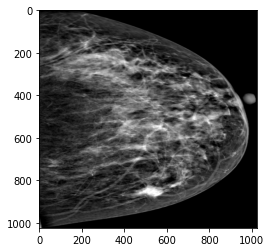

In [46]:
## Kiem tra kich thuoc anh
img = cv2.imread('CDD-CESM/Low energy images of CDD-CESM/P3_L_DM_CC.jpg')
img = cv2.resize(img, (1024, 1024))
plt.imshow(img)

In [50]:
# crop img
pro1 = Process_Data(data_cdd)
# pro1.set_path(3)
ls = list(data_cdd.index)
pro1.my_method(ls)

In [42]:
len(glob.glob('CDD-CESM-1024X512/*.png'))

331

## Data BMCD

In [7]:
meta_bmcd = pd.read_csv('BMCD_external.csv')
# meta_bmcd = meta_bmcd.drop('Unnamed: 0', axis=1)
# meta_bmcd = meta_bmcd[meta_bmcd.cancer == 1]
# for i in meta_bmcd.index:
#     meta_bmcd.patient_id[i] = int(meta_bmcd.patient_id[i].split('_')[0])

In [8]:
meta_bmcd

,Unnamed: 0,view,patient_id,image_id,age,laterality,cancer,img_path
0,0,CC,1_CC_recent,CC_recent,57,L,0,/kaggle/input/breast-microcalcifications-datas...
1,1,MLO,1_MLO_recent,MLO_recent,57,L,0,/kaggle/input/breast-microcalcifications-datas...
2,2,CC,2_CC_recent,CC_recent,64,L,0,/kaggle/input/breast-microcalcifications-datas...
3,3,MLO,2_MLO_recent,MLO_recent,64,L,0,/kaggle/input/breast-microcalcifications-datas...
4,4,CC,3_CC_recent,CC_recent,71,L,0,/kaggle/input/breast-microcalcifications-datas...
...,...,...,...,...,...,...,...,...
72,72,MLO,38_MLO_recent,MLO_recent,61,L,0,/kaggle/input/breast-microcalcifications-datas...
73,73,MLO,39_MLO_recent,MLO_recent,83,L,1,/kaggle/input/breast-microcalcifications-datas...
74,74,CC,39_CC_recent,CC_recent,83,L,1,/kaggle/input/breast-microcalcifications-datas...
75,75,CC,44_CC_recent,CC_recent,38,L,1,/kaggle/input/breast-microcalcifications-datas...


In [5]:
meta_bmcd

,view,patient_id,image_id,age,laterality,cancer,img_path
20,CC,11,CC_recent,54,L,1,/kaggle/input/breast-microcalcifications-datas...
21,MLO,11,MLO_recent,54,L,1,/kaggle/input/breast-microcalcifications-datas...
28,MLO,15,MLO_recent,56,L,1,/kaggle/input/breast-microcalcifications-datas...
29,CC,15,CC_recent,56,L,1,/kaggle/input/breast-microcalcifications-datas...
40,CC,21,CC_recent,53,L,1,/kaggle/input/breast-microcalcifications-datas...
41,MLO,21,MLO_recent,53,L,1,/kaggle/input/breast-microcalcifications-datas...
56,CC,30,CC_recent,68,L,1,/kaggle/input/breast-microcalcifications-datas...
57,MLO,30,MLO_recent,68,L,1,/kaggle/input/breast-microcalcifications-datas...
65,MLO,35,MLO_recent,60,L,1,/kaggle/input/breast-microcalcifications-datas...
66,CC,35,CC_recent,60,L,1,/kaggle/input/breast-microcalcifications-datas...


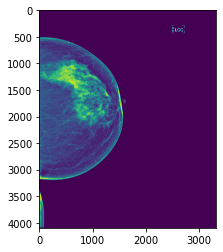

In [6]:
img = pydicom.dcmread("BMCD/Dataset/Dataset/Suspicious_cases/4/CC_recent.dcm")
plt.imshow(img.pixel_array)

ANH CHUA CAT

In [7]:
from scipy import stats as sst
from crop_image_for_you import *


In [9]:
# crop img
pro1 = Process_Data(meta_bmcd)
# pro1.set_path(3)
ls = list(meta_bmcd.index)
pro1.my_method(ls)

BỎ 

In [ ]:
"BMCD/Dataset/Dataset/Suspicious_cases/{image_id}"

## Sau khi kiem tra toi thay rang vu trai se nam o ben trai hinh, con phai se nam ben phai hinh

# Merger RSNA, Vindr

In [110]:
# Image_Id, views, age, cancer, laterality
meta_rsna = pd.read_csv('train.csv/train.csv')
meta_vindr = pd.read_csv('VinDr-Mammo_Origin_image/metadata.csv')

meta_rsna = meta_rsna.loc[:, ['image_id', 'view', 'age', 'laterality', 'cancer']]
d = "Patient's Age"
meta_vindr = meta_vindr.loc[:, ['SOP Instance UID.1', 'View Position', "Patient's Age", 'Image Laterality']]

In [111]:
find_id = pd.read_csv('VinDr-Mammo_Origin_image/finding_annotations.csv')
find_id[:1]

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.97998,1852.75,training


In [112]:
meta_vindr = meta_vindr.rename(columns={'SOP Instance UID.1': 'image_id', 'View Position': 'view', "Patient's Age": 'age', 'Image Laterality': 'laterality'})
cancer = []
for id in meta_vindr.image_id:
    name = find_id[find_id['image_id'] == id].breast_birads.values
    # print(name[0])
    # print(find_id[find_id['image_id'] == id].breast_birads.values)
    cancer.append(int(find_id[find_id['image_id'] == id].breast_birads.values[0] == 'BI-RADS 5'))

In [113]:
meta_vindr['cancer'] = cancer

In [114]:
meta_vindr = meta_vindr[meta_vindr['cancer'] == 1]

In [117]:
meta_rsna = meta_rsna[(meta_rsna.view == 'CC') | (meta_rsna.view == 'MLO')]
meta_rsna

,image_id,view,age,laterality,cancer
0,462822612,CC,61.0,L,0
1,1459541791,MLO,61.0,L,0
2,1864590858,MLO,61.0,R,0
3,1874946579,CC,61.0,R,0
4,220375232,CC,55.0,L,0
...,...,...,...,...,...
54701,1729524723,MLO,43.0,R,0
54702,63473691,MLO,60.0,L,0
54703,1078943060,CC,60.0,L,0
54704,398038886,MLO,60.0,R,0


In [118]:
vin_rsna = pd.concat([meta_rsna, meta_vindr]).reset_index()

In [119]:
vin_rsna = vin_rsna.drop('index', axis=1)
# vin_rsna.to_csv('meta_data_vinrsna.csv')

In [120]:
x = pd.read_csv('train.csv/train.csv')

In [121]:
for i in range(len(vin_rsna['age'])):
    print(type(vin_rsna.age[i])==float)
    if type(vin_rsna.age[i])!=float:
        vin_rsna.age[i] = vin_rsna.age[i].replace('Y', '')
        vin_rsna.age[i] = float(vin_rsna.age[i])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


C:\Users\nguye\AppData\Local\Temp\ipykernel_1132\216103713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vin_rsna.age[i] = vin_rsna.age[i].replace('Y', '')
C:\Users\nguye\AppData\Local\Temp\ipykernel_1132\216103713.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vin_rsna.age[i] = float(vin_rsna.age[i])


In [122]:
vin_rsna

,image_id,view,age,laterality,cancer
0,462822612,CC,61.0,L,0
1,1459541791,MLO,61.0,L,0
2,1864590858,MLO,61.0,R,0
3,1874946579,CC,61.0,R,0
4,220375232,CC,55.0,L,0
...,...,...,...,...,...
54889,19acc4b912b5637af651392bc1fe6b6e,CC,66.0,L,1
54890,19269b87da23b12053b3bfcfa65a2eeb,MLO,53.0,R,1
54891,42f76304c7825a09405739d899c6cd86,CC,53.0,R,1
54892,85a6579cbdc403cfc4dde0a8149ed855,MLO,34.0,R,1


### Meger with CMMD

In [123]:
data_cmmd_cancer = data_cmmd_cancer.rename(columns={'img_id':'image_id' })

In [124]:
data_cmmd_cancer = data_cmmd_cancer[['image_id', 'view', 'age', 'laterality', 'cancer']]
data_cmmd_cancer

,image_id,view,age,laterality,cancer
116,D1-0045_1-1,MLO,33,L,1
117,D1-0045_1-2,CC,33,L,1
118,D1-0046_1-1,MLO,43,R,1
119,D1-0046_1-2,CC,43,R,1
120,D1-0047_1-1,MLO,43,R,1
...,...,...,...,...,...
5580,D2-0747_1-4,CC,53,R,1
5583,D2-0748_1-3,MLO,29,R,1
5584,D2-0748_1-4,CC,29,R,1
5586,D2-0749_1-2,CC,42,L,1


In [125]:
vin_rsna_cmmd = pd.concat([vin_rsna, data_cmmd_cancer]).reset_index()

In [126]:
vin_rsna_cmmd = vin_rsna_cmmd.drop('index', axis=1)

In [127]:
vin_rsna_cmmd.age = vin_rsna_cmmd.age.astype('float')

In [128]:
vin_rsna_cmmd

,image_id,view,age,laterality,cancer
0,462822612,CC,61.0,L,0
1,1459541791,MLO,61.0,L,0
2,1864590858,MLO,61.0,R,0
3,1874946579,CC,61.0,R,0
4,220375232,CC,55.0,L,0
...,...,...,...,...,...
57522,D2-0747_1-4,CC,53.0,R,1
57523,D2-0748_1-3,MLO,29.0,R,1
57524,D2-0748_1-4,CC,29.0,R,1
57525,D2-0749_1-2,CC,42.0,L,1


In [112]:
ls_path = glob.glob('Data_Main_1024x512/Meta_data/*.png')
for id in range(len(vin_rsna_cmmd)):
    
    path = f'Data_Main_1024x512/Meta_data/{vin_rsna_cmmd.view[id]}_{vin_rsna_cmmd.image_id[id]}.png'
    try:
        img = cv2.imread(path)
    except:
        print(path)
    if os.path.exists(path):
        1
    else:
        print(path)

Data_Main_1024x512/Meta_data/ML_1671936115.png
Data_Main_1024x512/Meta_data/ML_1760744211.png
Data_Main_1024x512/Meta_data/LM_979422762.png
Data_Main_1024x512/Meta_data/LM_1754894704.png
Data_Main_1024x512/Meta_data/LM_1872785516.png
Data_Main_1024x512/Meta_data/AT_2082854771.png
Data_Main_1024x512/Meta_data/MLO_845708188.png
Data_Main_1024x512/Meta_data/CC_926797032.png
Data_Main_1024x512/Meta_data/LM_2130401243.png


In [129]:
vin_rsna_cmmd.to_csv('Data_Main_1024x512/meta_data.csv')

In [109]:
len(glob.glob('Data_Main_1024x512/meta_data/*.png'))

0

In [104]:
len(data_cmmd_cancer)

2633

In [101]:
cmmd = glob.glob('CMMD_1024x512foryou/*png')
for path in cmmd:
    # print(path)
    name = os.path.basename(path)
    # print(name)
    if 'CC' in name or 'MLO' in name:
        path1 = f'Data_Main_1024x512/Meta_data/{name}'
        shutil.move(path, path1)
        # print(path1)

In [28]:
rsna = glob.glob('RSNA_1024x512/RSNA_1024x512/*png')
for path in rsna:
    # print(path)
    name = os.path.basename(path)
    if 'CC' in name or 'MLO' in name:
        path1 = f'Data_Main/Meta_data/{name}'
        shutil.move(path, path1)
        # print(path1)

In [31]:
len(glob.glob('Vindr1024_512foryou/*.png'))

19774

In [37]:
vin = glob.glob('Vindr_cancer_1024x512_foryou/*png')
for path in vin:
    # print(path)
    name = os.path.basename(path)
    if 'CC' in name or 'MLO' in name:
        path1 = f'Data_Main/Meta_data/{name}'
        shutil.move(path, path1)

In [40]:
for i in range(len(vin_rsna)):
    path1 = f'Data_Main/Meta_data/{vin_rsna.view[i]}_{vin_rsna.image_id[i]}.png'
    img = cv2.imread(path1)
    
    path2 = f'Data_Main/Data_cancer/{vin_rsna.view[i]}_{vin_rsna.image_id[i]}.png'
    # shutil.move(path1, path2)
    try:
        imageio.imwrite(path2, img)
    except:
        print(path1)

Data_Main/Meta_data/AT_106495931.png
Data_Main/Meta_data/AT_1743461841.png


In [5]:
data = pd.read_csv("Data_Main_1024x512/meta_data.csv")
data

,Unnamed: 0,image_id,view,age,laterality,cancer
0,0,462822612,CC,61.0,L,0
1,1,1459541791,MLO,61.0,L,0
2,2,1864590858,MLO,61.0,R,0
3,3,1874946579,CC,61.0,R,0
4,4,220375232,CC,55.0,L,0
...,...,...,...,...,...,...
57560,57560,D2-0747_1-4,CC,53.0,R,1
57561,57561,D2-0748_1-3,MLO,29.0,R,1
57562,57562,D2-0748_1-4,CC,29.0,R,1
57563,57563,D2-0749_1-2,CC,42.0,L,1


In [7]:
data = data[data.view.isin(['CC', 'MLO'])]
data = data.drop('Unnamed: 0', axis=1)
data.to_csv("Data_Main_1024x512/meta_data.csv")

,image_id,view,age,laterality,cancer
0,462822612,CC,61.0,L,0
1,1459541791,MLO,61.0,L,0
2,1864590858,MLO,61.0,R,0
3,1874946579,CC,61.0,R,0
4,220375232,CC,55.0,L,0
...,...,...,...,...,...
57560,D2-0747_1-4,CC,53.0,R,1
57561,D2-0748_1-3,MLO,29.0,R,1
57562,D2-0748_1-4,CC,29.0,R,1
57563,D2-0749_1-2,CC,42.0,L,1


In [8]:
data.to_csv("Data_Main_1024x512/meta_data.csv")

### Meger with CDD-CESM

In [130]:
meta = pd.read_csv('Data_Main_1024x512/meta_data.csv')
meta

,Unnamed: 0,image_id,view,age,laterality,cancer
0,0,462822612,CC,61.0,L,0
1,1,1459541791,MLO,61.0,L,0
2,2,1864590858,MLO,61.0,R,0
3,3,1874946579,CC,61.0,R,0
4,4,220375232,CC,55.0,L,0
...,...,...,...,...,...,...
57522,57522,D2-0747_1-4,CC,53.0,R,1
57523,57523,D2-0748_1-3,MLO,29.0,R,1
57524,57524,D2-0748_1-4,CC,29.0,R,1
57525,57525,D2-0749_1-2,CC,42.0,L,1


In [131]:
data_cdd = data_cdd[['image_id', 'view', 'age', 'laterality', 'cancer']]

In [132]:
vin_rsna_cmmd_cdd = pd.concat([meta, data_cdd]).reset_index()

In [133]:
vin_rsna_cmmd_cdd =vin_rsna_cmmd_cdd[['image_id', 'view', 'age', 'laterality', 'cancer']]

In [134]:
vin_rsna_cmmd_cdd.to_csv('Data_Main_1024x512/meta_data.csv')

In [135]:
vin_rsna_cmmd_cdd.to_csv('Data_Main_1024x1024/meta_data.csv')

In [136]:
len(glob.glob('Data_Main_1024x512/Data_cancer/*.png'))

4346

In [142]:
vin_rsna_cmmd_cdd

,image_id,view,age,laterality,cancer
0,462822612,CC,61.0,L,0
1,1459541791,MLO,61.0,L,0
2,1864590858,MLO,61.0,R,0
3,1874946579,CC,61.0,R,0
4,220375232,CC,55.0,L,0
...,...,...,...,...,...
57853,P322_L_DM_MLO,MLO,76.0,L,1
57854,P323_L_DM_CC,CC,45.0,L,1
57855,P323_L_DM_MLO,MLO,45.0,L,1
57856,P326_L_DM_CC,CC,51.0,L,1


# Move file image RSNA

In [43]:
ls = glob.glob('RSNA_1024x1024_cancer/*.png')
for path in ls:
    name = os.path.basename(path)
    path1 = f'Data_Main_1024x1024/Data_cancer/{name}'
    shutil.move(path, path1)
    

In [45]:
ls = glob.glob('RSNA_1024x1024_nocancer/*.png')
for path in ls:
    name = os.path.basename(path)
    path1 = f'Data_Main_1024x1024/Data_nocaner/{name}'
    shutil.move(path, path1)

# Move file image Vindr

In [46]:
ls = glob.glob('Vindr_cancer_1024x1024_foryou/*.png')
for path in ls:
    name = os.path.basename(path)
    path1 = f'Data_Main_1024x1024/Data_cancer/{name}'
    shutil.move(path, path1)
    

# Move file image CMMD

In [47]:
ls = glob.glob('CMMD_1024x1024foryou/*.png')
for path in ls:
    name = os.path.basename(path)
    path1 = f'Data_Main_1024x1024/Data_cancer/{name}'
    shutil.move(path, path1)


# Move file image CDD-CESM

In [48]:
ls = glob.glob('CDD-CESM-1024X1024/*.png')
for path in ls:
    name = os.path.basename(path)
    path1 = f'Data_Main_1024x1024/Data_cancer/{name}'
    shutil.move(path, path1)

Kiem tra file 

In [137]:
len(glob.glob('Data_Main_1024x1024/Data_cancer/*.png'))

4346

In [138]:
len(glob.glob('Data_Main_1024x512/Data_cancer/*.png'))

4346

In [139]:
len(glob.glob('Data_Main_1024x1024/Data_nocancer/*.png'))

53512

In [140]:
len(glob.glob('Data_Main_1024x512/Data_nocancer/*.png'))

53512

In [141]:
53512 + 4346

57858

In [78]:
p1 = 53512/100
p1*3

1605.3600000000001

In [ ]:
## 6 % bo train
## 2 % bo test
## 1 % bo val


In [59]:
p2 = 4346/100
p2


43.46

In [60]:
p2*70

3042.2000000000003

### Cac file da du

# Chia data into train (70%), test (20), val (10)

In [7]:
from sklearn.model_selection import train_test_split


In [44]:
meta = pd.read_csv('D:\OneDrive - Industrial University of HoChiMinh City\WORKBASE\Project-rsna-breast-cancer-detection\DATA_STANDARD\DDSM.csv')
meta.drop('Unnamed: 0', axis=1, inplace=True)

In [45]:
meta

,patient_id,image_id,view,laterality,cancer
0,0001DDSM,0,CC,L,1
1,0001DDSM,1,MLO,L,1
2,0001DDSM,2,CC,R,1
3,0001DDSM,3,MLO,R,1
4,0002DDSM,4,CC,L,1
...,...,...,...,...,...
5119,4607DDSM,5119,MLO,R,0
5120,4608DDSM,5120,CC,L,0
5121,4608DDSM,5121,MLO,L,0
5122,4608DDSM,5122,CC,R,0


In [46]:
cancer_data = meta[meta.cancer == 1]
no_cancer_data = meta[meta.cancer == 0]

In [47]:
cancer_train, cancer_test_val = train_test_split(cancer_data, test_size=0.3, random_state=42)

In [48]:
len(cancer_train)

1901

In [49]:
cancer_val, cancer_test = train_test_split(cancer_test_val, test_size=0.2, random_state=42)


In [50]:
len(cancer_test)

163

In [51]:
len(cancer_val)

652

In [52]:
## 6 % bo train
## 65,8 % bo test
## 28,2 % bo val
no_cancer_train, no_cancer_test_val = train_test_split(no_cancer_data, test_size=0.3, random_state=42)

In [53]:
no_cancer_val, no_cancer_test = train_test_split(no_cancer_test_val,  test_size=0.2, random_state=42)

In [54]:
len(no_cancer_train), len(no_cancer_val) , len(no_cancer_test)

(1685, 578, 145)

In [55]:
len(cancer_train), len(cancer_val) , len(cancer_test)

(1901, 652, 163)

In [56]:
train = pd.concat([cancer_train, no_cancer_train], axis=0).reset_index().drop('index', axis=1)
test = pd.concat([cancer_test, no_cancer_test], axis=0).reset_index().drop('index', axis=1)
val = pd.concat([cancer_val, no_cancer_val], axis=0).reset_index().drop('index', axis=1)

In [57]:
class Evaluate:
    def __init__(self, meta_pro, name):
        self.al_data = meta_pro.reset_index()
        self.name = name
    def quatity_cc_mlo(self):
        return f"\nSo luong CC và MLO\n{self.al_data.view.value_counts()}\n"
        # print(self.al_data.view.value_counts())
    def lelf_right(self):
        return f"\nSo luong L và R\n{self.al_data.groupby(['view', 'laterality']).size()}\n"
        # print(self.al_data.groupby(['view', 'laterality']).size())
    def show_one(self, par):
        return self.al_data[self.al_data.patient_id == par]
    def quanlity_cancer(self):
        sl = len(self.al_data[self.al_data.cancer == 1])
        return f"So luong img cancer: {sl}"
        # print(self.al_data[self.al_data.cancer == 1])
    def show(self, path):
        ls = len(self.al_data)
        par = len(self.al_data.patient_id.unique())
        # print( 
        # self.quatity_cc_mlo()
        # self.lelf_right()
        # self.quanlity_cancer()
        f = open(path, 'a', encoding='utf-8')
        f.write(f'Dataset {self.name} \n Số lượng image: {ls} \n Số luong patient: {par} {self.quatity_cc_mlo()} {self.lelf_right()} {self.quanlity_cancer()}\n\n +++++++++++++++\n\n')
        f.close()

In [58]:
def save(cancer_train, nocancer_train, cancer_val, nocancer_val, cancer_test, nocancer_test, name = "Rong",  name_folder = "Rong"):
    path = f'D:/OneDrive - Industrial University of HoChiMinh City/WORKBASE/Project-rsna-breast-cancer-detection/Data_main/CSV_MAIN/{name_folder}/{name}'
    os.makedirs(path)
    train = pd.concat([cancer_train, nocancer_train]).reset_index().drop('index', axis=1)
    val = pd.concat([cancer_val, nocancer_val]).reset_index().drop('index', axis=1)
    test = pd.concat([cancer_test, nocancer_test]).reset_index().drop('index', axis=1)
    # test = pd.read_csv(r'D:/OneDrive - Industrial University of HoChiMinh City/WORKBASE/Project-rsna-breast-cancer-detection\DATA_STANDARD\DDSM.csv', index_col='Unnamed: 0')
    ev = Evaluate(train, "Train")
    ev1 = Evaluate(val, "Val")
    ev2 = Evaluate(test, "Test")
    ev.show(f'{path}/description.txt')
    ev1.show(f'{path}/description.txt')
    ev2.show(f'{path}/description.txt')
    train.to_csv(f'D:/OneDrive - Industrial University of HoChiMinh City/WORKBASE/Project-rsna-breast-cancer-detection/Data_main/CSV_MAIN/{name_folder}/{name}/train.csv')
    val.to_csv(f'D:/OneDrive - Industrial University of HoChiMinh City/WORKBASE/Project-rsna-breast-cancer-detection/Data_main/CSV_MAIN/{name_folder}/{name}/val.csv')
    test.to_csv(f'D:/OneDrive - Industrial University of HoChiMinh City/WORKBASE/Project-rsna-breast-cancer-detection/Data_main/CSV_MAIN/{name_folder}/{name}/test.csv')

In [43]:
save(cancer_train, no_cancer_train, cancer_val, no_cancer_val, cancer_test, no_cancer_test,'rate11', 'DDSM')

In [22]:
len(test)

15621

In [23]:
len(val)

1737

In [25]:
train.to_csv("Data_Main/Data_Main/Data_Main_1024x512/train.csv")
# train.to_csv("Data_Main/Data_Main/Data_Main_1024x1024/train.csv")

In [26]:
test
test.to_csv("Data_Main/Data_Main_1024x512/test.csv")
# test.to_csv("Data_Main/Data_Main_1024x1024/test.csv")

In [193]:
val
val.to_csv("Data_Main/Data_Main_1024x512/val.csv")
# val.to_csv("Data_Main/Data_Main_1024x1024/val.csv")

In [198]:
(len(test)/(4346 + 53512))*100

62.88499429638079

In [199]:
100 - 10.8 - 62.9

26.300000000000004

In [ ]:
# import os
# import pandas as pd
# from torchvision.io import read_image

In [ ]:
# import torch
# import torchvision
# from torchvision import transforms

In [ ]:
# transform1 = transforms.Compose([
#                     transforms.ToTensor(),
#                     transforms.Resize((224, 224)),
#                     transforms.Normalize([0.5], [0.5]),
#                     transforms.RandomHorizontalFlip(p=0.5),
#                     transforms.RandomRotation(10)]
    
# )
# transform2 = transforms.Compose([
#                     transforms.ToTensor(),
#                     transforms.Resize((224, 224)),
#                     transforms.Normalize([0.5], [0.5])]
    
# )

In [ ]:
# class Dataset_for_RSNA():
#     def __init__(self, data, transform=True, augment = True, type_data = 'RNSA'):
#         self.type = type_data
#         self.data = data
#         self.process = Process_Data(self.data)
#         self.transform = transform
#         self.augment = augment
#     def __len__(self):
#         return len(self.data)
#     def __getitem__(self, idx):
        
#         self.process.set_path(idx)
#         img = self.process.crop_image()
#         label = self.process.get_info()[-1]
#         # Train for train set
#         if self.augment and label == 1:
#             img = transform1(img)
#         else : 
#             # Train for train val, test
#             img = transform2(img)
            
#         return img, label
        

In [ ]:
# train_set = data_train.sample(frac=0.7, random_state = 42).reset_index(drop=True)
# train_val = data_train.sample(frac=0.2, random_state = 42).reset_index(drop=True)
# train_test = data_train.sample(frac=0.1, random_state = 42).reset_index(drop=True)
# print(train_set.shape[0], train_val.shape, train_test.shape)

In [ ]:
# train_set

In [ ]:
# # train_dataset = Dataset_for_RSNA(train_set, transform=True, augment = True)
# val_dataset = Dataset_for_RSNA(train_val, transform=True, augment = False)
# test_dataset = Dataset_for_RSNA(train_test, transform=True, augment = False)

### Show image
+ Tại sao chúng ta không thể sử dụng hàm show như bình thường trong pytorch
Vì định dạng ảnh trong pytorch nó theo dạng là (batch_size, channels, height, width) trong đó batch_size là số lượng ảnh trong một lô
Tuy nhiên, Matplotlib yêu cầu ảnh có dạng (height, width, channels) để hiển thị chính vì vậy chúng ta phải sử dụng torch.squeeze() để loại bỏ các đối số của pytorch và giữ lại các tính chất của hình ảnh

In [ ]:
# # for i in range(100):
# #     ls = random.randint(0, train_set.shape[0])
# # ls = 1
# img, label = train_dataset.__getitem__(20)

# plt.imshow(img.squeeze(), cmap='gray')
# plt.title(f'{label}')
# plt.show()


In [ ]:
# batch_size = 64

# train_dataloader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(train_val, batch_size = batch_size, shuffle = False)

Giải thích:
+ torch.utils.data.DataLoader là một lớp trong PyTorch cung cấp một iterable cho một tập dữ liệu PyTorch được cung cấp. Nó cho phép bạn tải một tập dữ liệu thành các batch và cung cấp một số tùy chọn để tùy chỉnh quá trình tải dữ liệu.
+ Train_set: là bộ dữ liệu của mình
+ batch_size là kích thước của mỗi nhóm, ví dụ như ta có 1000 mẫu thì chia mỗi batch là 100 thì sẽ xử lý 1000 mẫu cùng một lúc
+ shuffle: True nếu muốn trộn mẫu

## DataLoader

In [22]:
data = pd.read_csv('Data_Main_1024x512/meta_data.csv')
data

,Unnamed: 0,image_id,view,age,laterality,cancer
0,0,462822612,CC,61.0,L,0
1,1,1459541791,MLO,61.0,L,0
2,2,1864590858,MLO,61.0,R,0
3,3,1874946579,CC,61.0,R,0
4,4,220375232,CC,55.0,L,0
...,...,...,...,...,...,...
57522,57560,D2-0747_1-4,CC,53.0,R,1
57523,57561,D2-0748_1-3,MLO,29.0,R,1
57524,57562,D2-0748_1-4,CC,29.0,R,1
57525,57563,D2-0749_1-2,CC,42.0,L,1


In [ ]:
plt.d